In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.preprocessing import FunctionTransformer
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, StandardScaler

import warnings
warnings.filterwarnings('ignore')

In [2]:
df_init = pd.read_csv('../data/cirrhosis.csv')

In [3]:
df_init = df_init.drop(['ID'], axis=1)

In [4]:
df_init

,N_Days,Status,Drug,Age,Sex,Ascites,Hepatomegaly,Spiders,Edema,Bilirubin,Cholesterol,Albumin,Copper,Alk_Phos,SGOT,Tryglicerides,Platelets,Prothrombin,Stage
0,400,D,D-penicillamine,21464,F,Y,Y,Y,Y,14.5,261.0,2.60,156.0,1718.0,137.95,172.0,190.0,12.2,4.0
1,4500,C,D-penicillamine,20617,F,N,Y,Y,N,1.1,302.0,4.14,54.0,7394.8,113.52,88.0,221.0,10.6,3.0
2,1012,D,D-penicillamine,25594,M,N,N,N,S,1.4,176.0,3.48,210.0,516.0,96.10,55.0,151.0,12.0,4.0
3,1925,D,D-penicillamine,19994,F,N,Y,Y,S,1.8,244.0,2.54,64.0,6121.8,60.63,92.0,183.0,10.3,4.0
4,1504,CL,Placebo,13918,F,N,Y,Y,N,3.4,279.0,3.53,143.0,671.0,113.15,72.0,136.0,10.9,3.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
413,681,D,NaN,24472,F,NaN,NaN,NaN,N,1.2,NaN,2.96,NaN,NaN,NaN,NaN,174.0,10.9,3.0
414,1103,C,NaN,14245,F,NaN,NaN,NaN,N,0.9,NaN,3.83,NaN,NaN,NaN,NaN,180.0,11.2,4.0
415,1055,C,NaN,20819,F,NaN,NaN,NaN,N,1.6,NaN,3.42,NaN,NaN,NaN,NaN,143.0,9.9,3.0
416,691,C,NaN,21185,F,NaN,NaN,NaN,N,0.8,NaN,3.75,NaN,NaN,NaN,NaN,269.0,10.4,3.0


Задача - по медицинским показателем прогнозировать выживание пациентов. Из всех столбцов больше всего на target похож Status

In [5]:
df_init['Status'].value_counts()

Status
C     232
D     161
CL     25
Name: count, dtype: int64

Т.к. в описании датасета не указано, что означают эти значения, попробуем интерпретировать их через ChatGPT:

* C (Cured): Это может означать, что пациент был "вылечен" или что заболевание находится в состоянии устойчивой ремиссии. В контексте хронических заболеваний, таких как цирроз печени, полное излечение может быть редкостью, поэтому это обычно относится к значительному улучшению состояния.  

* D (Died): Это обычно обозначает, что пациент умер. В контексте цирроза печени это может быть результатом прогрессирования заболевания или связанных осложнений.  

* CL (Clinical Follow-up): Это может означать "клиническое наблюдение" или "клиническое продолжение". Такое обозначение используется, когда пациент продолжает находиться под медицинским наблюдением или проходит дальнейшее лечение. Это может указывать на то, что заболевание не прогрессирует, но пациент по-прежнему требует регулярного мониторинга и возможного лечения.  

Так как данных со значением CL не так много, к тому же расшифровка этой аббревиатуры до конца не известна, было принято решение убрать этот класс из датасета и решать задачу бинарной классификации

In [6]:
df_init = df_init[df_init['Status']!='CL']

In [7]:
df = df_init.copy()

In [8]:
# Анализ датасета на наличие пропущенных значений (NaN)
missing_values = df.isnull().sum()

# Вычисление процента пропущенных значений для каждого столбца
missing_percentage = (missing_values / len(df)) * 100

# Проверка корреляции пропущенных значений с таргетом 'Status'
# Сначала преобразуем категориальные данные в числовые
data_numeric = df.copy()
status_mapping = {'C': 0, 'D': 1}
data_numeric['Status'] = df['Status'].map(status_mapping)

In [9]:
df.loc[:, ['Status_int']] = df['Status'].map(status_mapping)

In [10]:
# Вывод информации о пропущенных значениях
missing_values_summary = pd.DataFrame({
    'Missing Values': missing_values,
    'Percentage': missing_percentage
})

In [11]:
missing_values_summary

,Missing Values,Percentage
N_Days,0,0.000000
Status,0,0.000000
Drug,100,25.445293
Age,0,0.000000
Sex,0,0.000000
Ascites,100,25.445293
Hepatomegaly,100,25.445293
Spiders,100,25.445293
Edema,0,0.000000
Bilirubin,0,0.000000


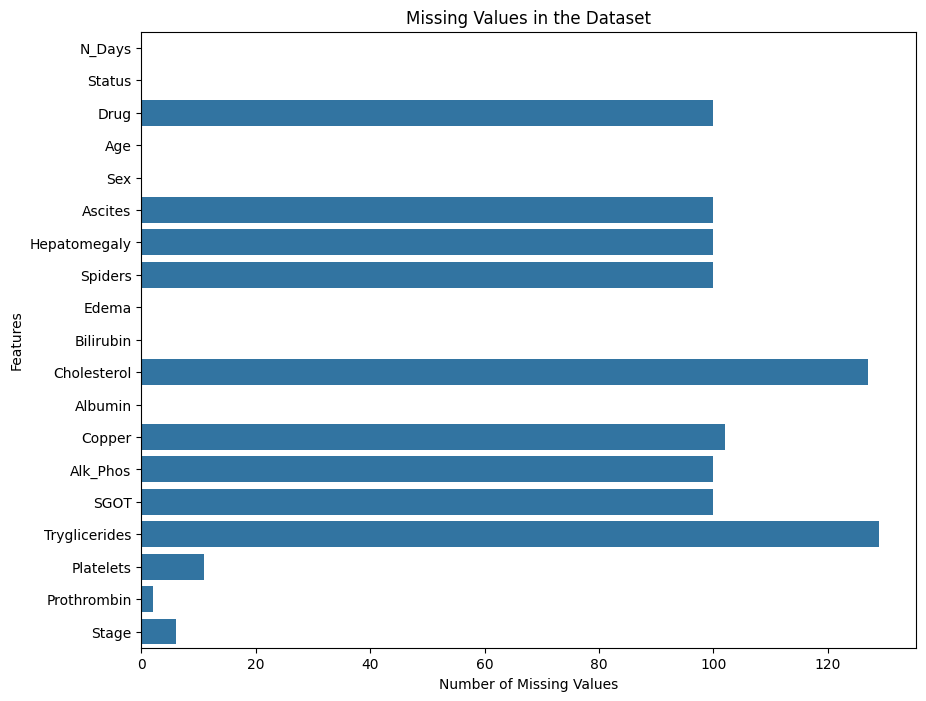

In [12]:
# График пропущенных значений
plt.figure(figsize=(10, 8))
sns.barplot(x=missing_values.values, y=missing_values.index)
plt.title('Missing Values in the Dataset')
plt.xlabel('Number of Missing Values')
plt.ylabel('Features')
plt.show()

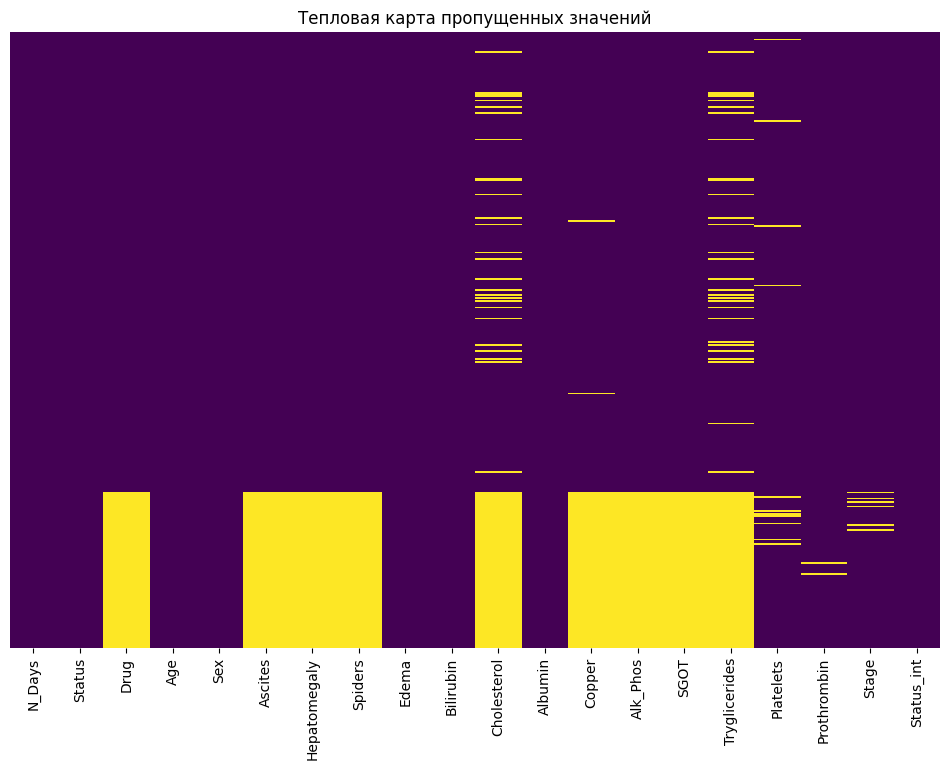

In [13]:
missing_values = df.isnull()

# Создание тепловой карты
plt.figure(figsize=(12, 8))
sns.heatmap(missing_values, cbar=False, yticklabels=False, cmap='viridis')
plt.title('Тепловая карта пропущенных значений')
plt.show()

Видим, что данные, скорее всего, собирались с разных источников, и многие признаки пропущены для нижней части датафрема. Вероятно, эти анализы сложнее сделать, поэтому попробуем получить хорошее качество без них. Перед этим посмотрим на 

In [14]:
def calculate_missing_counts(df):
    missing_counts = df.isnull().sum(axis=1)
    return missing_counts

In [15]:
missing_counts = calculate_missing_counts(df)

In [16]:
threshold = 9
high_missing_values = missing_counts[missing_counts >= threshold]
indexes = high_missing_values.index
print(indexes)

df.loc[indexes]['Status'].value_counts()

Index([312, 313, 314, 315, 316, 317, 318, 319, 320, 321, 322, 323, 324, 325,
       326, 327, 328, 329, 330, 331, 332, 333, 334, 335, 336, 337, 338, 339,
       340, 341, 342, 343, 345, 346, 347, 348, 349, 350, 351, 352, 353, 354,
       355, 356, 357, 358, 359, 362, 363, 364, 365, 366, 367, 368, 369, 370,
       371, 372, 373, 375, 376, 377, 378, 380, 381, 383, 384, 385, 386, 387,
       388, 389, 390, 391, 392, 393, 394, 395, 396, 397, 398, 399, 400, 401,
       402, 403, 404, 405, 406, 407, 408, 409, 410, 411, 412, 413, 414, 415,
       416, 417],
      dtype='int64')


Status
C    64
D    36
Name: count, dtype: int64

Посмотрим, где больше 10 признаков отсутствуют

In [17]:
threshold = 10
high_missing_values = missing_counts[missing_counts >= threshold]
indexes = high_missing_values.index
print(indexes)

df.loc[indexes]['Status'].value_counts()

Index([312, 315, 316, 318, 321, 324, 326, 327, 332, 333, 336, 342, 346, 358,
       367],
      dtype='int64')


Status
D    10
C     5
Name: count, dtype: int64

Также добавим к каждому столбцу ещё один столбец: missing. Пропуски заполним средним. Добавим столбец с общим количеством пропущенных значений

In [18]:
for column in df.columns:
    missing = df[column].isnull()

    # if missing.any():
    if df[column].dtype == 'float64':
        df.loc[:, [column]] = df[column].fillna(df[column].mean())
        df.loc[:, [column + '_missing']] = missing
    elif df[column].dtype == 'object':
        df.loc[:, [column]] = df[column].fillna('missed')

df.loc[:, ['n_missing']] = missing_counts

In [19]:
numeric_columns = data_numeric.select_dtypes(include=['float64', 'int64'])
correlation_with_target_numeric = numeric_columns.corr()['Status'].sort_values()

In [20]:
correlation_with_target_numeric

N_Days          -0.420457
Albumin         -0.270806
Platelets       -0.094446
Cholesterol      0.198065
Age              0.208877
Tryglicerides    0.219346
Alk_Phos         0.229272
SGOT             0.297176
Stage            0.325894
Prothrombin      0.348222
Copper           0.403340
Bilirubin        0.437845
Status           1.000000
Name: Status, dtype: float64

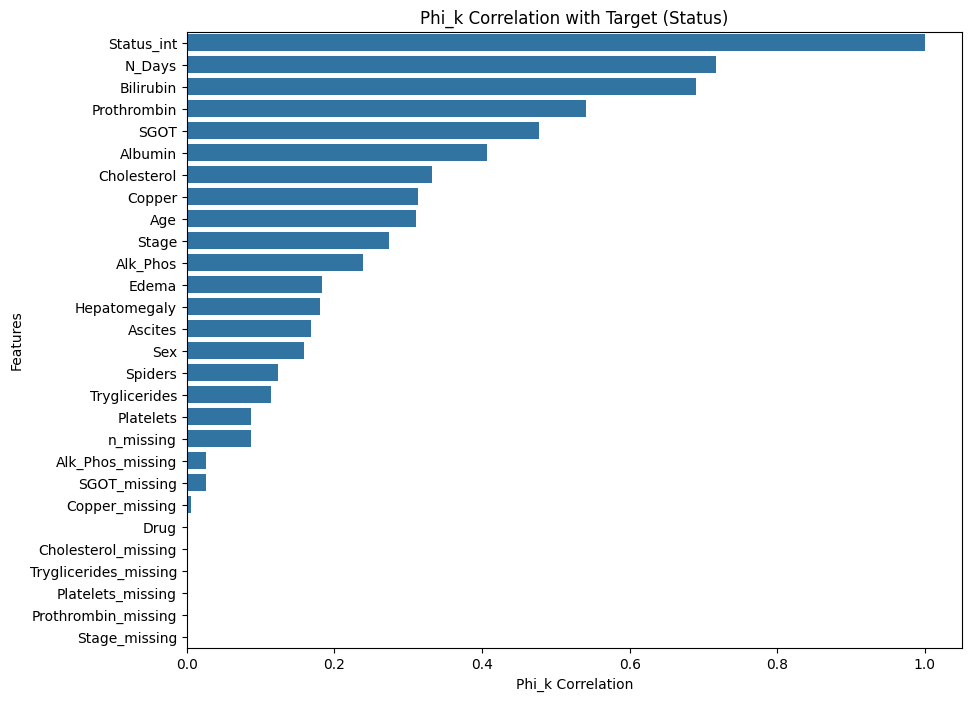

In [21]:
import phik
from phik.report import plot_correlation_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Вычисление корреляции phi_k для всех переменных с таргетом
phik_correlation = df.drop(['Status'], axis=1).phik_matrix(interval_cols=['Status_int'])

# Фильтрация для получения только корреляций с таргетом
phik_correlation_with_target = phik_correlation['Status_int'].sort_values(ascending=False)

# График корреляций
plt.figure(figsize=(10, 8))
sns.barplot(x=phik_correlation_with_target.values, y=phik_correlation_with_target.index)
plt.title('Phi_k Correlation with Target (Status)')
plt.xlabel('Phi_k Correlation')
plt.ylabel('Features')
plt.show()

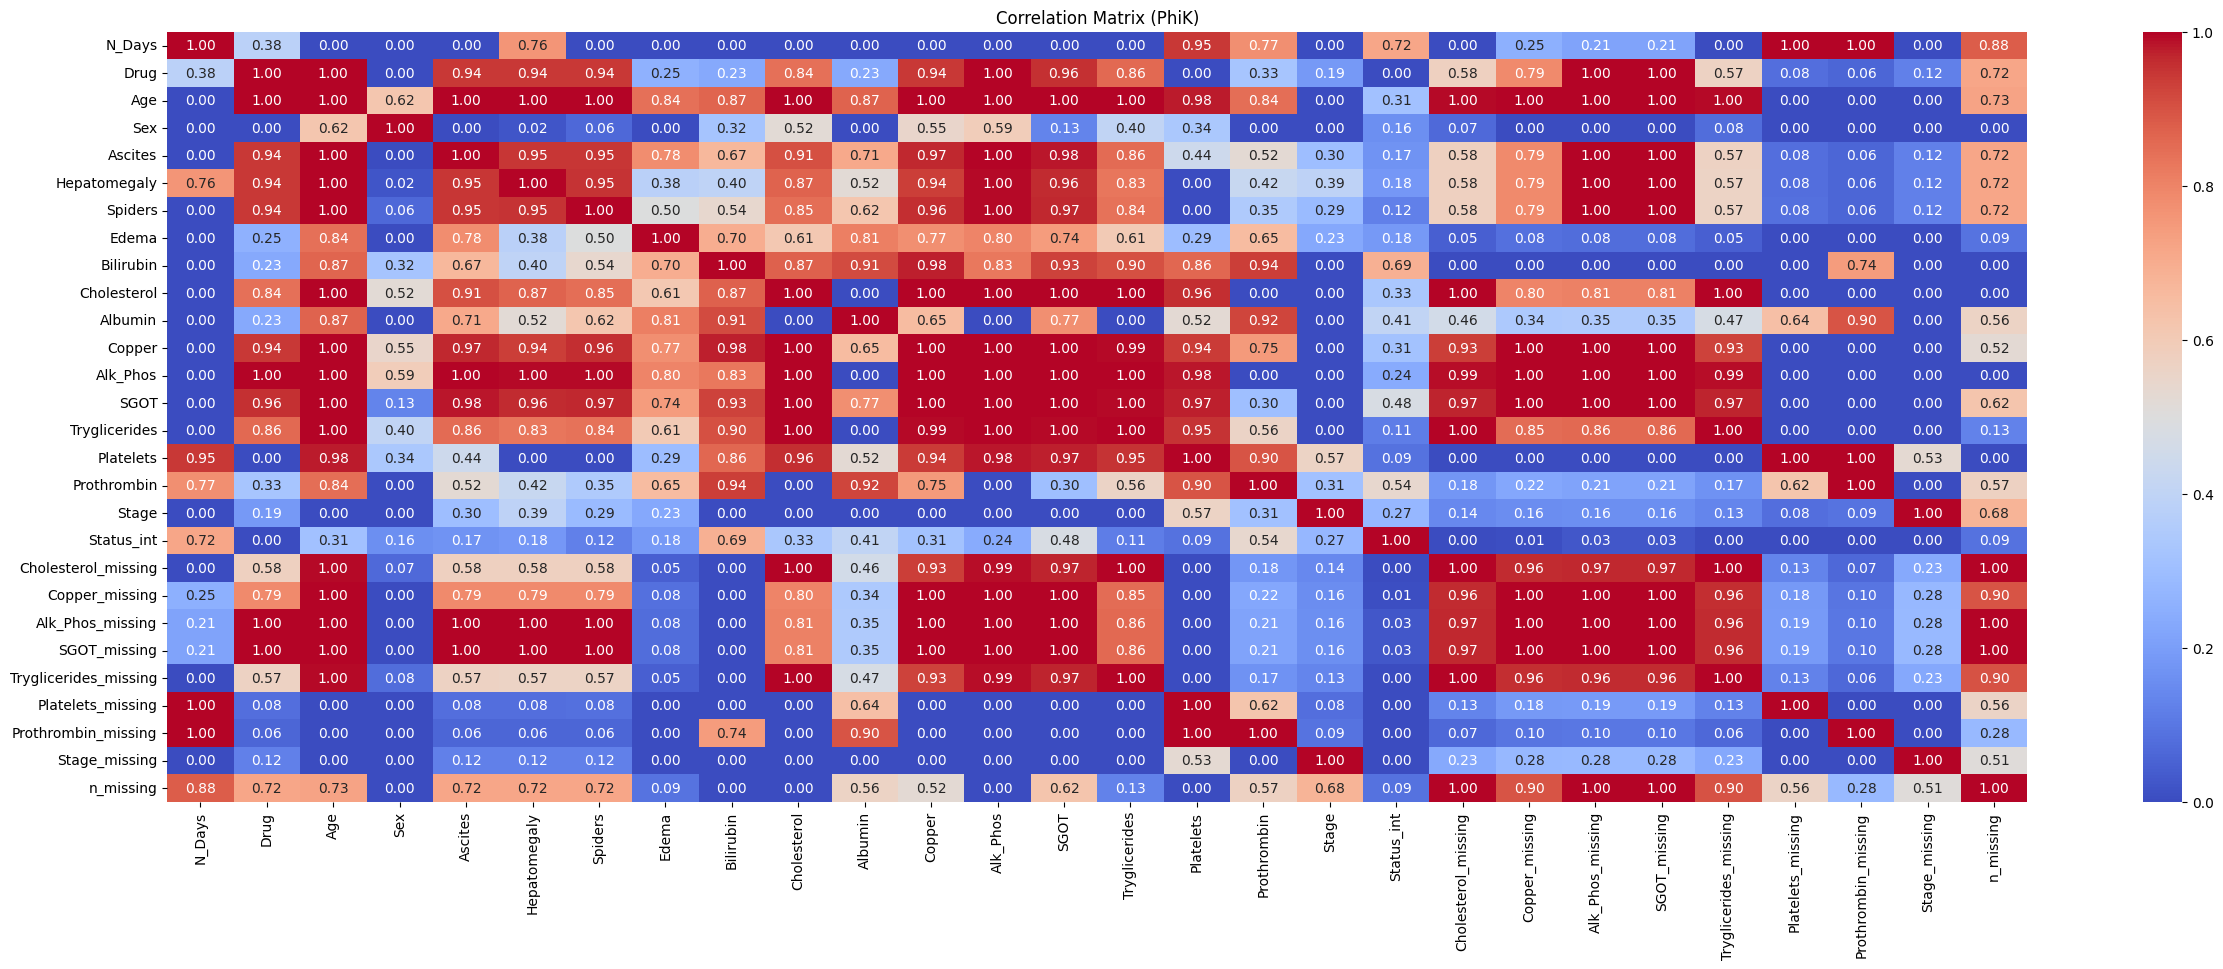

In [22]:
plt.figure(figsize=(30, 10))
sns.heatmap(phik_correlation, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Matrix (PhiK)')
plt.show()

Данные сильно скореллированы между собой, поэтому линейные модели (и полносвязные нейронки) использовать с осторожностью и доп предобработкой

# Preprocessing Pipeline

In [23]:
for column in df_init.columns:
    print(column, df_init[column].dtype)

N_Days int64
Status object
Drug object
Age int64
Sex object
Ascites object
Hepatomegaly object
Spiders object
Edema object
Bilirubin float64
Cholesterol float64
Albumin float64
Copper float64
Alk_Phos float64
SGOT float64
Tryglicerides float64
Platelets float64
Prothrombin float64
Stage float64


In [24]:
df_init

,N_Days,Status,Drug,Age,Sex,Ascites,Hepatomegaly,Spiders,Edema,Bilirubin,Cholesterol,Albumin,Copper,Alk_Phos,SGOT,Tryglicerides,Platelets,Prothrombin,Stage
0,400,D,D-penicillamine,21464,F,Y,Y,Y,Y,14.5,261.0,2.60,156.0,1718.0,137.95,172.0,190.0,12.2,4.0
1,4500,C,D-penicillamine,20617,F,N,Y,Y,N,1.1,302.0,4.14,54.0,7394.8,113.52,88.0,221.0,10.6,3.0
2,1012,D,D-penicillamine,25594,M,N,N,N,S,1.4,176.0,3.48,210.0,516.0,96.10,55.0,151.0,12.0,4.0
3,1925,D,D-penicillamine,19994,F,N,Y,Y,S,1.8,244.0,2.54,64.0,6121.8,60.63,92.0,183.0,10.3,4.0
5,2503,D,Placebo,24201,F,N,Y,N,N,0.8,248.0,3.98,50.0,944.0,93.00,63.0,NaN,11.0,3.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
413,681,D,NaN,24472,F,NaN,NaN,NaN,N,1.2,NaN,2.96,NaN,NaN,NaN,NaN,174.0,10.9,3.0
414,1103,C,NaN,14245,F,NaN,NaN,NaN,N,0.9,NaN,3.83,NaN,NaN,NaN,NaN,180.0,11.2,4.0
415,1055,C,NaN,20819,F,NaN,NaN,NaN,N,1.6,NaN,3.42,NaN,NaN,NaN,NaN,143.0,9.9,3.0
416,691,C,NaN,21185,F,NaN,NaN,NaN,N,0.8,NaN,3.75,NaN,NaN,NaN,NaN,269.0,10.4,3.0


In [25]:
cat_features_init = df_init.select_dtypes(include=['object']).columns
cat_features_init = list(cat_features_init.drop('Status'))
numeric_features_init = df_init.select_dtypes(include=['float64', 'int64']).columns
numeric_features_init = list(numeric_features_init)

In [26]:
cat_features_init

['Drug', 'Sex', 'Ascites', 'Hepatomegaly', 'Spiders', 'Edema']

In [27]:
numeric_features_init

['N_Days',
 'Age',
 'Bilirubin',
 'Cholesterol',
 'Albumin',
 'Copper',
 'Alk_Phos',
 'SGOT',
 'Tryglicerides',
 'Platelets',
 'Prothrombin',
 'Stage']

In [28]:
def drop_id_status_function(df):
    if 'ID' in df.columns:
        df.drop(['ID'], axis=1, inplace=True)
    if 'Status' in df.columns:
        df.drop(['Status'], axis=1, inplace=True)
    return df

def add_missing_counts_function(df):
    df.loc[:, ['n_missing']] = calculate_missing_counts(df)
    return df

In [29]:
def add_is_missing_function(df):
    for column in df.columns:
        missing = df[column].isnull()
        df.loc[:, [column + '_missing']] = missing
    return df

In [30]:
df_copy = FunctionTransformer(lambda x: x.copy())
drop_id_status = FunctionTransformer(drop_id_status_function)
add_missing_counts = FunctionTransformer(add_missing_counts_function)
add_is_missing = FunctionTransformer(add_is_missing_function)

In [31]:
numerical_pipeline = Pipeline(steps=[
    ('add_is_missing', add_is_missing),
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', StandardScaler())
])

categorical_pipeline = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('one_hot_encoder', OneHotEncoder())
])

# Объединение числового и категориального пайплайнов в один с использованием FeatureUnion или ColumnTransformer
columns_preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_pipeline, numeric_features_init),  # numerical_columns - список имен числовых столбцов
        ('cat', categorical_pipeline, cat_features_init)  # categorical_columns - список имен категориальных столбцов
])

pipeline = Pipeline(steps=[
    ('df_copy', df_copy),
    ('drop_id_status', drop_id_status),
    ('add_missing_counts', add_missing_counts),
    ('columns_preprocessor', columns_preprocessor)
])

In [32]:
pipeline.fit(df_init)

Pipeline(steps=[('df_copy',
                 FunctionTransformer(func=<function <lambda> at 0x0000020535DC79A0>)),
                ('drop_id_status',
                 FunctionTransformer(func=<function drop_id_status_function at 0x0000020535DC7AC0>)),
                ('add_missing_counts',
                 FunctionTransformer(func=<function add_missing_counts_function at 0x0000020535DC7B50>)),
                ('columns_preprocessor',
                 ColumnTransformer(transform...
                                                                   SimpleImputer()),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['N_Days', 'Age', 'Bilirubin',
                                                   'Cholesterol', 'Albumin',
                                                   'Copper', 'Alk_Phos', 'SGOT',
                                                   'Tryglicerides', 'Platelets',
                                                   'Prothrombin', 'Stage']),
                                                 ('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('one_hot_encoder',
                                                                   OneHotEncoder())]),
                                                  ['Drug', 'Sex', 'Ascites',
                                                   'Hepatomegaly', 'Spiders',
                                                   'Edema'])]))])

In [33]:
%%time
pipeline.transform(df_init).shape

CPU times: total: 78.1 ms
Wall time: 37.1 ms


(393, 37)

# Разделение на трейн и тест

In [34]:
from sklearn.model_selection import train_test_split

In [35]:
X = df_init.drop(['Status'], axis=1)

status_mapping = {'C': 0, 'D': 1}
y = np.array(df_init['Status'].map(status_mapping))

In [36]:
X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle=True, stratify=y, test_size=0.1, random_state=42)

In [37]:
X_train

,N_Days,Drug,Age,Sex,Ascites,Hepatomegaly,Spiders,Edema,Bilirubin,Cholesterol,Albumin,Copper,Alk_Phos,SGOT,Tryglicerides,Platelets,Prothrombin,Stage
218,2157,Placebo,15601,F,N,N,N,N,1.6,215.0,4.17,67.0,936.0,134.85,85.0,176.0,9.6,3.0
133,3149,Placebo,15463,F,N,N,N,N,0.7,578.0,3.67,35.0,1353.0,127.10,105.0,427.0,10.7,2.0
178,2573,Placebo,16050,F,N,Y,N,N,1.8,396.0,3.83,39.0,2148.0,102.30,133.0,278.0,9.9,4.0
67,4039,D-penicillamine,11912,F,N,N,N,N,0.7,174.0,4.09,58.0,642.0,71.30,46.0,203.0,10.6,3.0
378,597,NaN,23011,F,NaN,NaN,NaN,S,3.3,NaN,2.73,NaN,NaN,NaN,NaN,224.0,11.1,4.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
158,1536,Placebo,16714,M,N,N,N,N,2.5,317.0,3.46,217.0,714.0,130.20,140.0,207.0,10.1,3.0
195,2363,D-penicillamine,20834,F,N,Y,Y,N,1.4,226.0,3.36,13.0,810.0,72.85,62.0,117.0,11.6,4.0
310,839,D-penicillamine,13879,F,N,N,N,N,2.0,247.0,3.16,69.0,1050.0,117.00,88.0,335.0,10.5,2.0
23,4079,D-penicillamine,16261,M,N,Y,N,N,2.1,456.0,4.00,124.0,5719.0,221.88,230.0,70.0,9.9,2.0


In [38]:
pipeline.fit(X_train)

Pipeline(steps=[('df_copy',
                 FunctionTransformer(func=<function <lambda> at 0x0000020535DC79A0>)),
                ('drop_id_status',
                 FunctionTransformer(func=<function drop_id_status_function at 0x0000020535DC7AC0>)),
                ('add_missing_counts',
                 FunctionTransformer(func=<function add_missing_counts_function at 0x0000020535DC7B50>)),
                ('columns_preprocessor',
                 ColumnTransformer(transform...
                                                                   SimpleImputer()),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['N_Days', 'Age', 'Bilirubin',
                                                   'Cholesterol', 'Albumin',
                                                   'Copper', 'Alk_Phos', 'SGOT',
                                                   'Tryglicerides', 'Platelets',
                                                   'Prothrombin', 'Stage']),
                                                 ('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('one_hot_encoder',
                                                                   OneHotEncoder())]),
                                                  ['Drug', 'Sex', 'Ascites',
                                                   'Hepatomegaly', 'Spiders',
                                                   'Edema'])]))])

In [39]:
X_train = pipeline.transform(X_train)
X_test = pipeline.transform(X_test)

In [40]:
from sklearn.metrics import (
    accuracy_score, confusion_matrix, precision_score, 
    recall_score, f1_score, roc_auc_score, roc_curve, auc
)
import matplotlib.pyplot as plt

def test_binary_classification_model(model, X_test, y_test):
    # Получение предсказаний модели
    y_pred = model.predict(X_test)
    y_pred_proba = model.predict_proba(X_test)[:, 1]

    # Вычисление метрик
    acc = accuracy_score(y_test, y_pred)

    # print(y_test)
    # print(y_pred)
    conf_matrix = confusion_matrix(y_test, y_pred)
    prec = precision_score(y_test, y_pred)
    rec = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    roc_auc = roc_auc_score(y_test, y_pred_proba)
    normalized_conf_matrix = conf_matrix.astype('float') / conf_matrix.sum(axis=1)[:, np.newaxis]
    
    # Вывод метрик
    print(f"Accuracy: {acc:.4f}")
    print(f"Precision: {prec:.4f}")
    print(f"Recall: {rec:.4f}")
    print(f"F1 Score: {f1:.4f}")
    print(f"ROC AUC Score: {roc_auc:.4f}")
    
    # Построение ROC кривой
    fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
    plt.plot(fpr, tpr, label=f'ROC curve (area = {roc_auc:.4f})')
    plt.plot([0, 1], [0, 1], 'k--')  # Случайный уровень классификации
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic')
    plt.legend(loc="lower right")
    plt.show()

    # Построение Confusion Matrix
    sns.heatmap(normalized_conf_matrix, annot=True, fmt='.2f', cmap='Blues')
    plt.title('Normalized Confusion Matrix')
    plt.ylabel('Actual label')
    plt.xlabel('Predicted label')
    plt.show()

# RandomForestClassifier

In [41]:
from sklearn.ensemble import RandomForestClassifier
rf = RandomForestClassifier(n_estimators=1000, max_depth=7, n_jobs=-1, random_state=42)
rf.fit(X_train, y_train)

RandomForestClassifier(max_depth=7, n_estimators=1000, n_jobs=-1,
                       random_state=42)

Accuracy: 0.8500
Precision: 0.8125
Recall: 0.8125
F1 Score: 0.8125
ROC AUC Score: 0.8802


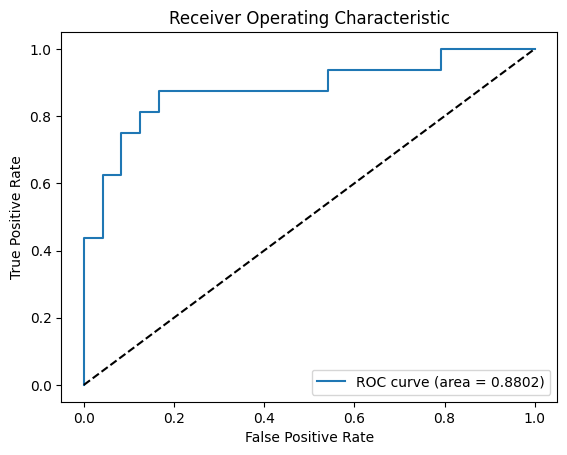

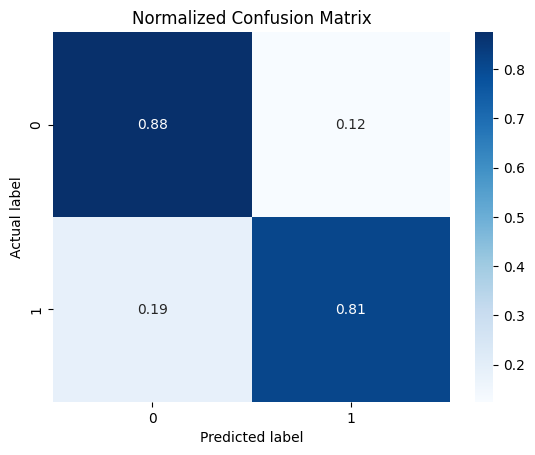

In [42]:
test_binary_classification_model(rf, X_test, y_test)

# CatBoostClassifier

In [43]:
from catboost import CatBoostClassifier

In [44]:
cb = CatBoostClassifier(n_estimators=1000, depth=7, random_state=42)
cb.fit(X_train, y_train, eval_set=(X_test, y_test), verbose=200)

Learning rate set to 0.024502
0:	learn: 0.6773614	test: 0.6767365	best: 0.6767365 (0)	total: 134ms	remaining: 2m 13s
200:	learn: 0.1464773	test: 0.3928514	best: 0.3928514 (200)	total: 1.44s	remaining: 5.74s
400:	learn: 0.0611300	test: 0.3605336	best: 0.3596838 (394)	total: 2.67s	remaining: 3.99s
600:	learn: 0.0293366	test: 0.3475150	best: 0.3415739 (521)	total: 3.95s	remaining: 2.62s
800:	learn: 0.0178629	test: 0.3628691	best: 0.3415739 (521)	total: 5.22s	remaining: 1.3s
999:	learn: 0.0126303	test: 0.3713953	best: 0.3415739 (521)	total: 6.55s	remaining: 0us

bestTest = 0.3415738689
bestIteration = 521

Shrink model to first 522 iterations.


Accuracy: 0.8500
Precision: 0.8125
Recall: 0.8125
F1 Score: 0.8125
ROC AUC Score: 0.9245


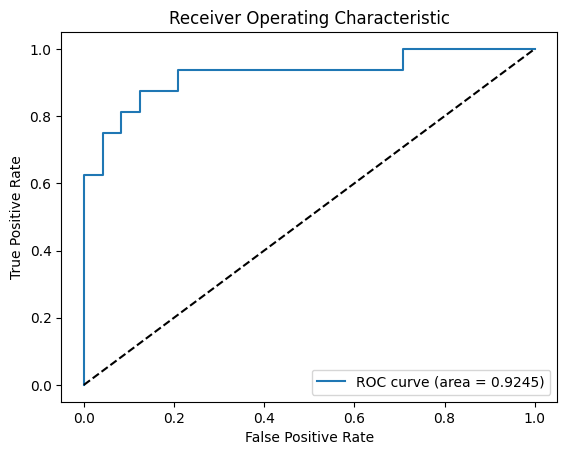

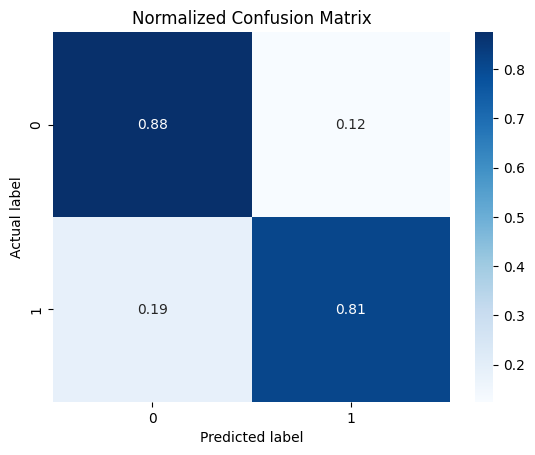

In [45]:
test_binary_classification_model(cb, X_test, y_test)

# SVM

In [46]:
from sklearn.svm import SVC

svm = SVC(random_state=42, kernel='poly', probability=True)  # 'rbf', 'poly', 'linear', 'sigmoid', 'precomputed'
svm.fit(X_train, y_train)

SVC(kernel='poly', probability=True, random_state=42)

Accuracy: 0.8500
Precision: 0.8571
Recall: 0.7500
F1 Score: 0.8000
ROC AUC Score: 0.8854


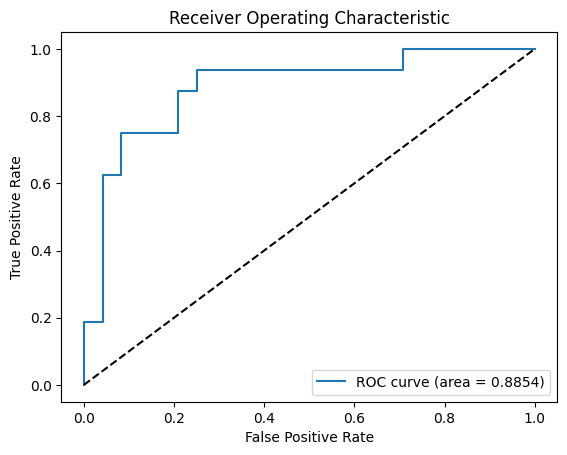

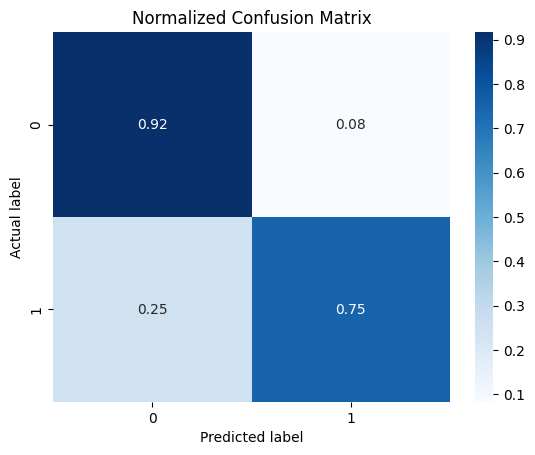

In [47]:
test_binary_classification_model(svm, X_test, y_test)

# QDA

In [48]:
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis

In [49]:
qda = QuadraticDiscriminantAnalysis()
qda.fit(X_train, y_train)

QuadraticDiscriminantAnalysis()

Accuracy: 0.7250
Precision: 0.8571
Recall: 0.3750
F1 Score: 0.5217
ROC AUC Score: 0.8346


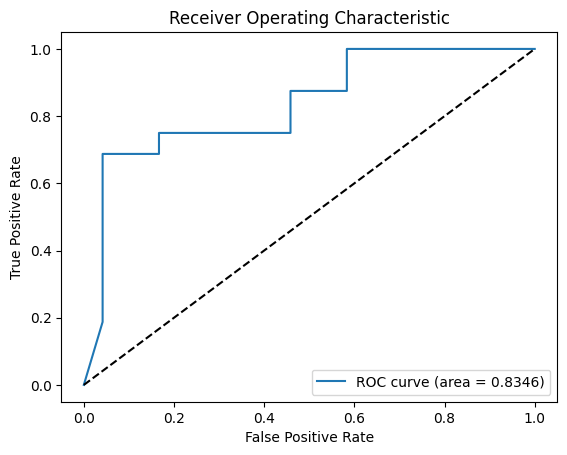

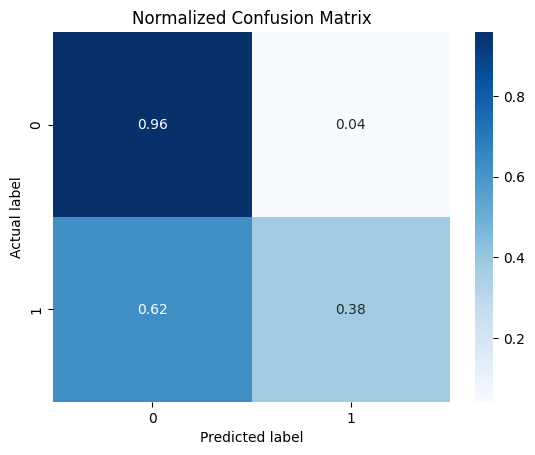

In [50]:
test_binary_classification_model(qda, X_test, y_test)

# Сохранение моделей

Таким образом, лучшие модели это Random Forest, CatBoost, SVM. Сохраним их

In [51]:
import dill
import os
from pathlib import Path

In [52]:
def save_model(model, model_name, path='.'):
    if not os.path.exists(path):
        os.makedirs(path)
    with open(f'{path}/{model_name}.dill', 'wb') as f:
        dill.dump(model, f)

In [53]:
def load_model(model_name, path='.'):
    with open(f'{path}/{model_name}.dill', 'rb') as f:
        return dill.load(f)

In [54]:
def save_and_load_model(model, model_name):
    save_model(model, model_name)
    return load_model(model_name)

In [55]:
pipeline = save_and_load_model(pipeline, 'preprocessing_pipeline')
status_mapping = save_and_load_model(status_mapping, 'status_mapping')

rf = save_and_load_model(rf, 'random_forest')
cb = save_and_load_model(cb, 'catboost')
svm = save_and_load_model(svm, 'svm')

In [56]:
transformed_df = pipeline.transform(df_init)

In [57]:
y = np.array(df_init['Status'].map(status_mapping))

In [58]:
type(rf)

sklearn.ensemble._forest.RandomForestClassifier

In [59]:
rf.predict(transformed_df)

array([1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 1, 0, 1, 0, 1, 1,
       1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 0, 1, 0, 0, 1, 0,
       1, 0, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 0, 1, 0,
       0, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1,
       1, 1, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 1, 1, 1,
       1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0,
       1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0,
       0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0,
       1, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1,
       0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 1,
       0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0,

In [60]:
type(cb)

catboost.core.CatBoostClassifier

In [61]:
cb.predict(transformed_df)

array([1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 0, 1, 1,
       1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 0, 1, 0, 0, 1, 0,
       1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 1, 1, 0, 1, 1,
       0, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1,
       1, 1, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1,
       1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0,
       1, 0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0,
       0, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0,
       1, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1,
       0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 1,
       0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0,

In [62]:
type(svm)

sklearn.svm._classes.SVC

In [63]:
svm.predict(transformed_df)

array([1, 0, 1, 1, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 1, 1, 0, 1, 0, 1, 1,
       1, 0, 1, 1, 1, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0,
       1, 0, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0, 1,
       0, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0,
       0, 1, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1,
       0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0,
       1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0,
       0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       1, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0,
       0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1,
       0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0,